In [21]:
import pandas as pd
import numpy as np
import datetime
import os 
import matplotlib.pyplot as plt 
import pickle
from datetime import datetime
from IPython.core.debugger import set_trace
import collections
import fbprophet
from fbprophet import Prophet
import utils
from calendar import day_abbr, month_abbr, mdays

import seaborn as sns
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.dates as mdates
from matplotlib.dates import date2num

In [22]:
#date = f'{datetime.now():%Y-%m-%d}'
date = '2021-01-04'
save_dir = os.path.join(date)
results_dir = 'results'
cov_file = 'covid19-interventionmeasures/COVID19_non-pharmaceutical-interventions_version2_utf8.csv'
df = pd.read_csv(cov_file, encoding = 'cp1252 ')

countries = ['DE', 'GB', 'IT', 'CH', 'CZ', 'ES', 'FR', 'NL', 'PL']

In [23]:
tw= 'hotel'  
collect = {}
for country in countries:
    with open(os.path.join(save_dir, '{}_daily_weekly.p'.format(country)), 'rb') as file:
        collect_daily, _ = pickle.load( file) 
    collect[country] = collect_daily[tw][tw]
        

In [24]:
cases = pd.read_excel('COVID-19-geographic-disbtribution-worldwide-2020-12-14.xlsx')

In [25]:
def get_country_measure(df, country, measure):
    tmp = df[df.Country==country].set_index('Date')[[measure]]
    return tmp

def get_country_cases(df, country):
    tmp = df[df['countriesAndTerritories']==country]
    tmp = tmp[['dateRep', 'cases', 'deaths', 'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000']].set_index('dateRep')
    tmp = tmp.rename(columns={'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000':'cum14'})
    tmp['deaths'].clip(lower=0, inplace=True) #clip negative deaths to 0s
#     scaler = MinMaxScaler()
#     tmp['cases'] = scaler.fit_transform(tmp['cases'].values.reshape(-1,1))
#     scaler = MinMaxScaler()
#     tmp['deaths'] = scaler.fit_transform(tmp['deaths'].values.reshape(-1,1))
#     scaler = MinMaxScaler()
#     tmp['cum14'] = scaler.fit_transform(tmp['cum14'].values.reshape(-1,1))
    return tmp

In [6]:
cnames_interv = ['Germany', 'United Kingdom', 'Italy', 'Switzerland', 'Czech Republic', 'Spain', 'France',
                 'Netherlands', 'Poland']
cnames_cases = ['Germany', 'United_Kingdom', 'Italy', 'Switzerland', 'Czechia', 'Spain', 'France', 
               'Netherlands', 'Poland']

Germany
United Kingdom
Italy
Switzerland
Czech Republic
Spain
France
Netherlands
Poland


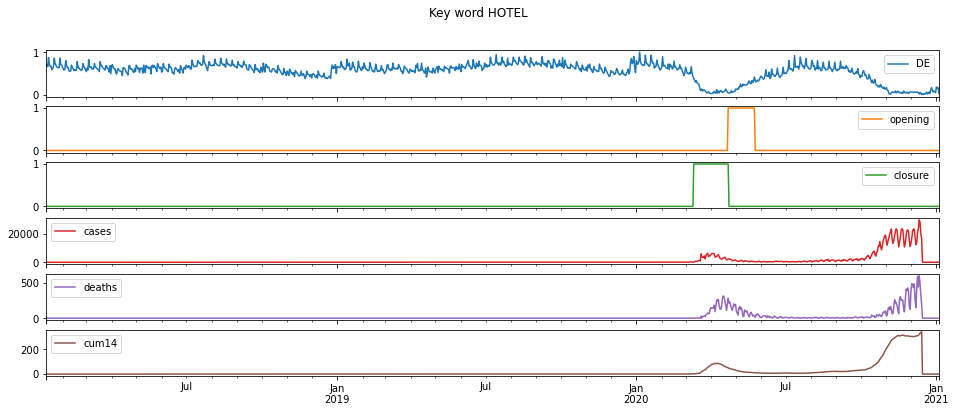

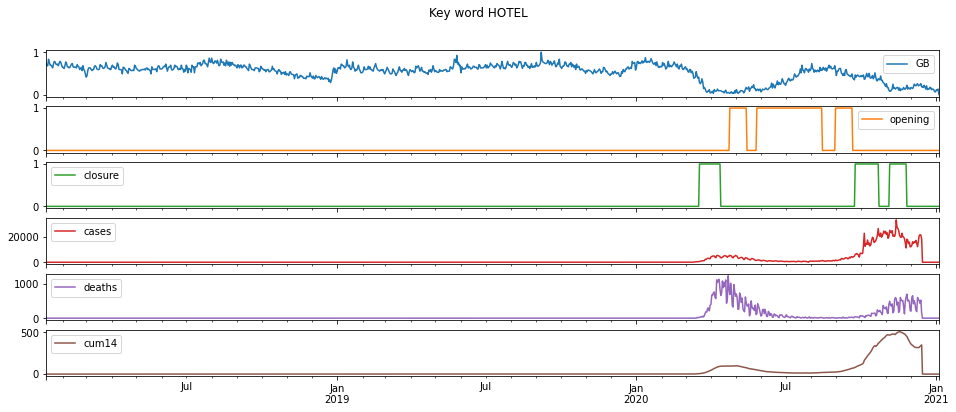

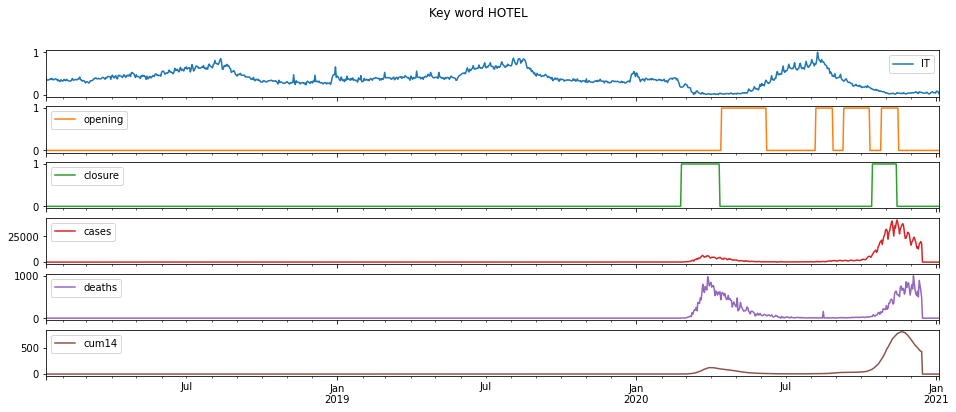

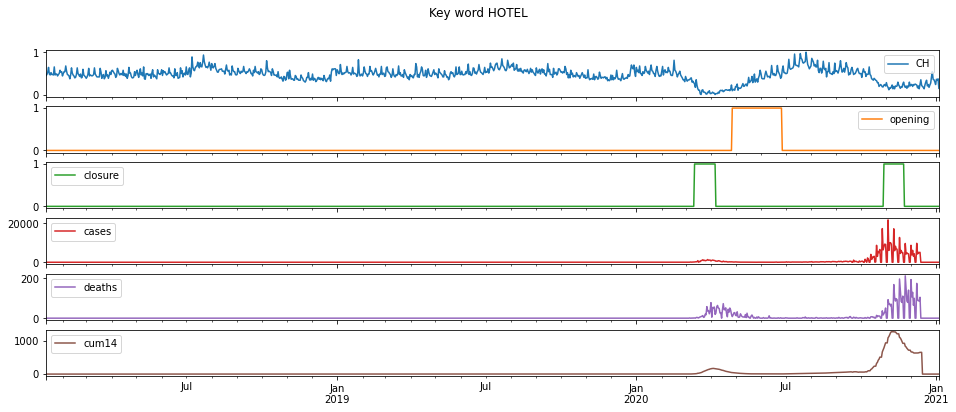

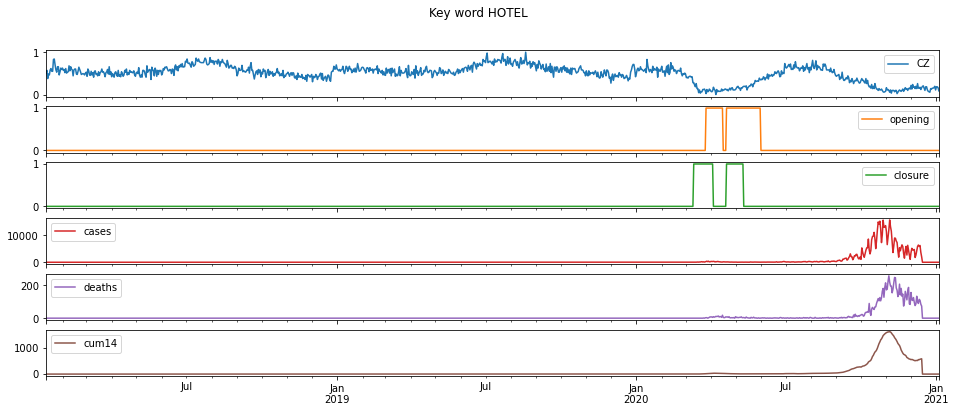

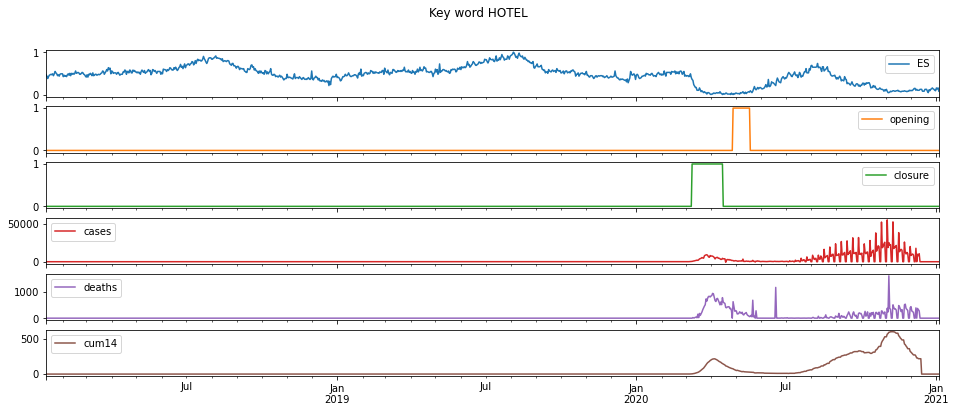

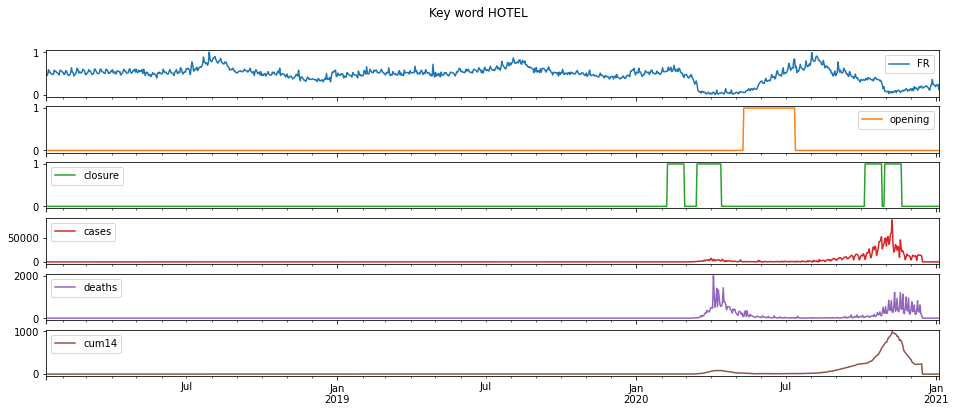

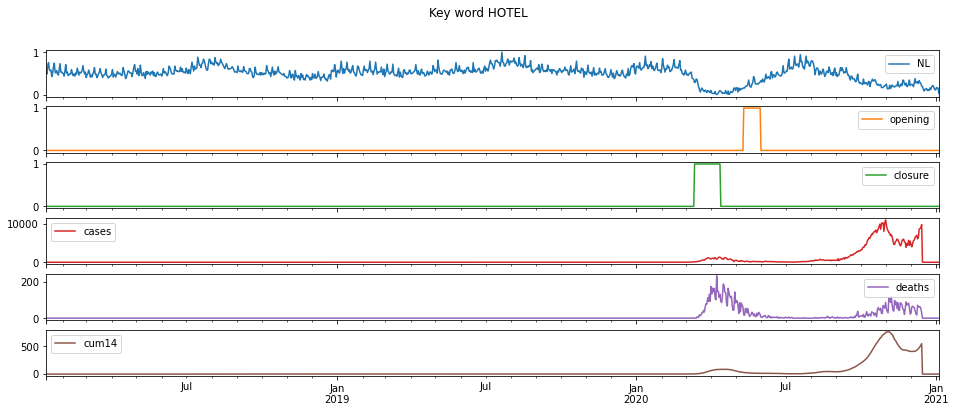

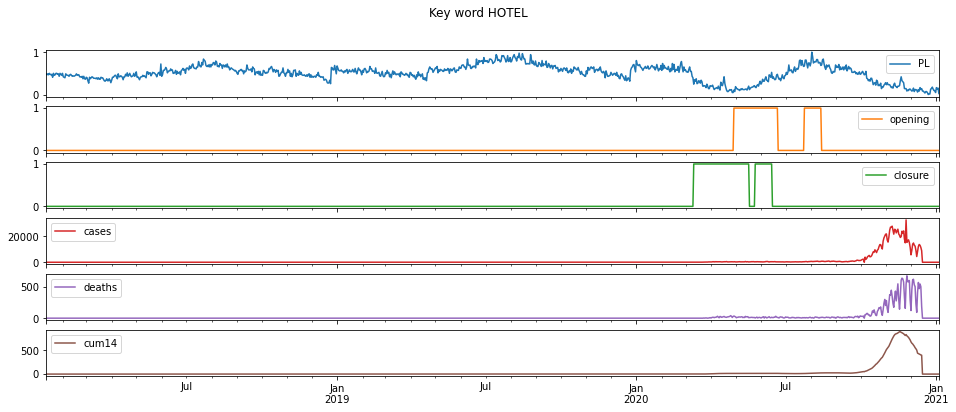

In [7]:
months = mdates.MonthLocator()  
ctuple = tuple(zip(cnames_interv,
                 countries,
                 cnames_cases,
                 ))

measure_name = 'Measure_L3'
trends = pd.concat(collect, 1)

outs = []
for country, abrev1, abrev2 in ctuple:
    print(country)
    measure = get_country_measure(df, country, measure_name) 
    measure = measure.drop_duplicates()
    measure = measure.dropna(subset=[measure_name])
    tmin = measure.sort_index().index[0]
    tmax = measure.sort_index().index[-1]
    #Concatenate if more than one per day
    measure = measure.groupby(measure.index)[measure_name].apply(','.join)
    measure = measure[tmin:tmax]
    trend = trends.copy()[[abrev1]]
    scaler = MinMaxScaler()
    trend[abrev1] = scaler.fit_transform(trend[abrev1].values.reshape(-1,1))
    
    measure.index = pd.to_datetime(measure.index)
    out = trend.join(measure, how='left')
    open_ = out[measure_name].str.contains('open', case=False)
    out['opening'] = open_.fillna(0).astype('int').rolling(21).max()
    close_ = out[measure_name].str.contains('closure', case=False)
    out['closure'] = close_.fillna(0).astype('int').rolling(21).max()
    
    closing_time = out.index[out['closure'] ==1][0]
    
    case = get_country_cases(cases, abrev2)
    out = out.join(case, how='left').fillna(0)
    outs.append(out)
    out.plot(subplots=True, figsize=(16,6))
    plt.suptitle('Key word {}'.format(tw.upper()))
    #plt.savefig(os.path.join(results_dir, abrev1, 'traces.jpg'))


In [8]:
def add_regressor_to_future(future, regressors_df): 
    futures = future.copy()    
    futures.index = pd.to_datetime(futures.ds)
    futures = futures.merge(regressors_df, left_index=True, right_index=True)
    futures = futures.reset_index(drop = True)
    return futures

In [9]:
def add_regressor_to_future_with_nocorona(future, regressors_df): 
    futures = future.copy()    
    futures.index = pd.to_datetime(futures.ds)
    #futures = futures.merge(regressors_df, left_index=True, right_index=True)
    
    futures = futures.merge(regressors_df, left_index=True, right_index=True, how='outer')
    futures = futures.fillna(0)
    #set_trace()
    futures = futures.reset_index(drop = True)
    return futures

In [10]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [11]:
def prepara_data(datas, c):
    #set_trace()
    data = [d for d in datas if c in d.columns][0]
    data = data.reset_index()
    data = data.dropna(subset=[c])
    data = data.rename(columns=dict(zip(data.columns[:2], ['ds', 'y'])))
    data['ds']= pd.to_datetime(data['ds'])
    data.dropna(inplace=True)
    data = data.set_index('ds')
    return data


In [12]:
def get_forecast(d, split, variable, add_regressor):
    m = Prophet(yearly_seasonality=20, changepoint_prior_scale=0.01)
    if add_regressor:
        for v in variable:
            m.add_regressor(v,  prior_scale=0.01, mode='multiplicative')
            #m.add_regressor(v,  prior_scale=0.01, mode='additive')
        
    train =  d.loc[:split].iloc[:-1].reset_index(drop=False)
    test = d.loc[split_time:].reset_index(drop=False)
    m.fit(train)
    extrasample = 100
    future = m.make_future_dataframe(periods=len(test)+extrasample, freq='1D')
    if add_regressor:
        future = add_regressor_to_future_with_nocorona(future, data[variable])
    forecast = m.predict(future)
    return forecast

## Compare forecasting of a model with and without corona deaths as an extra regressor

DE


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0691


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0842
GB


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE   0.1


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0958
IT


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0496
MAE 0.069
CH


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0729


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0847
CZ


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.165


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0764
ES


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0708


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0736
FR


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0861


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0792
NL


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0724


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.074
PL


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.247
MAE 0.0769


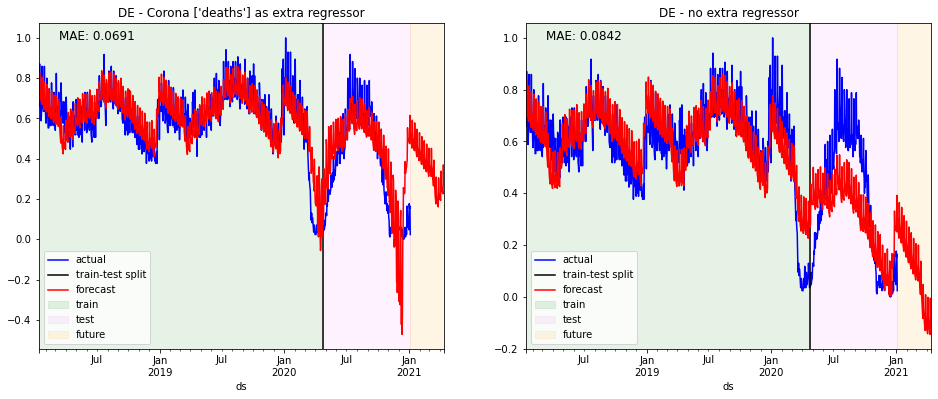

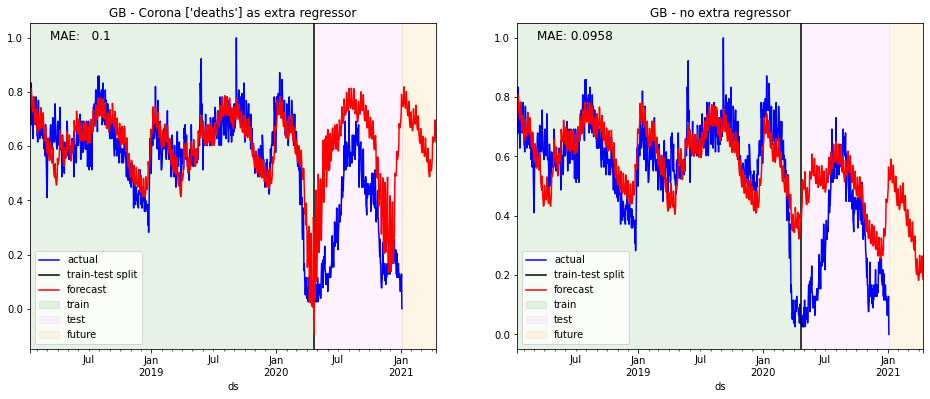

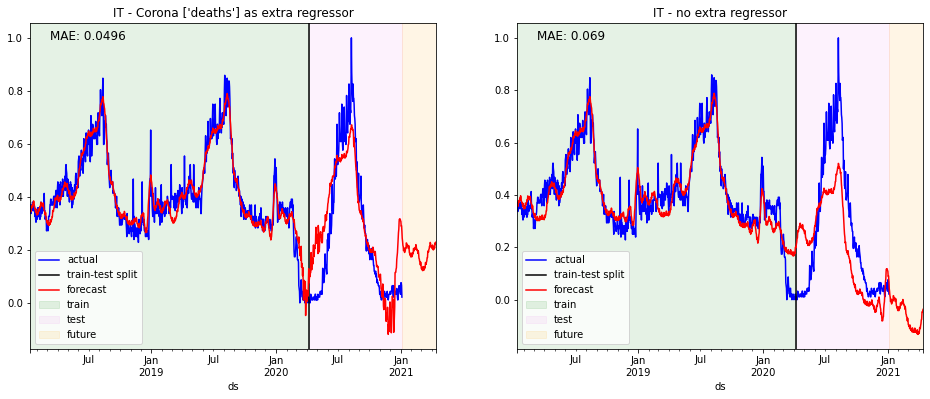

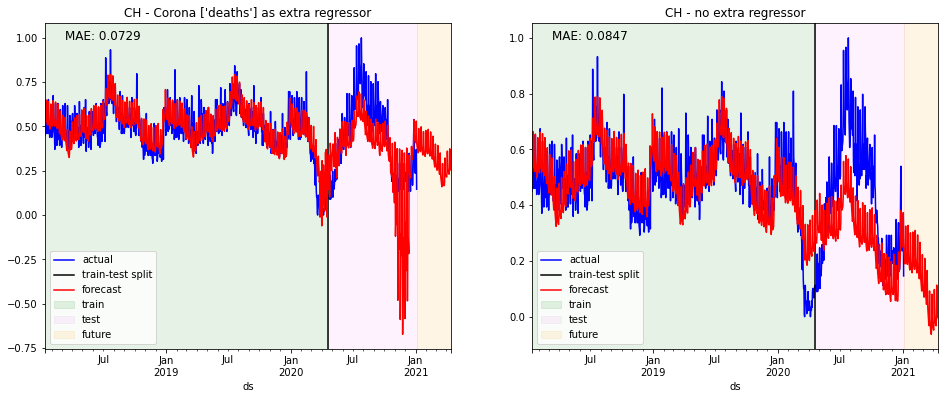

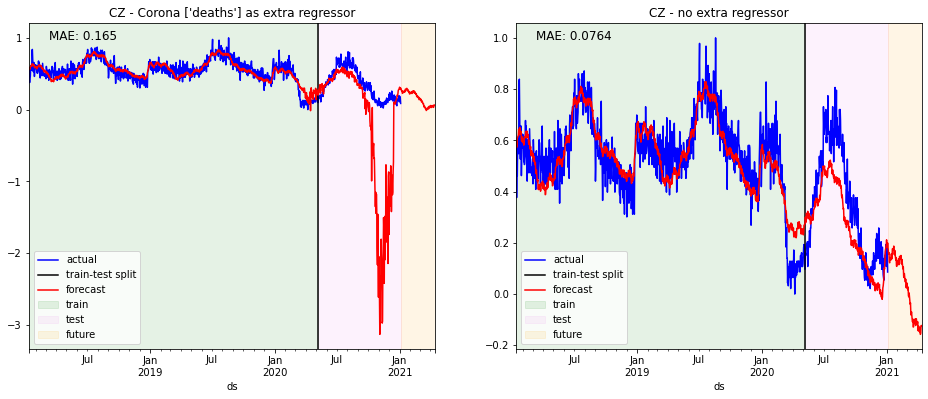

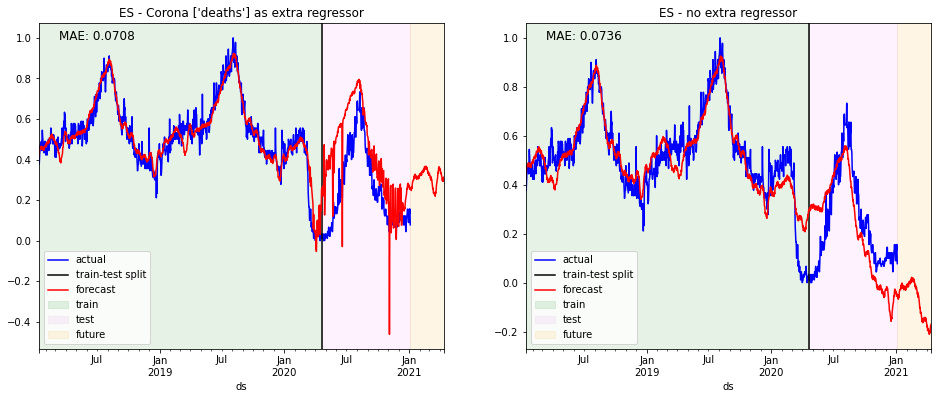

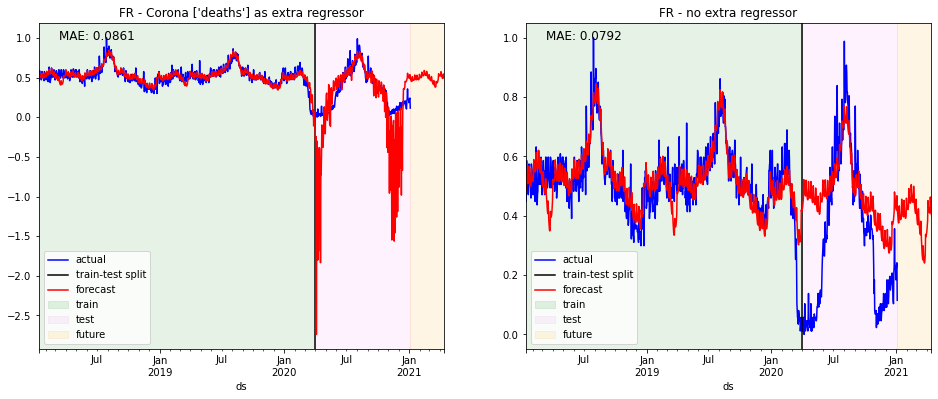

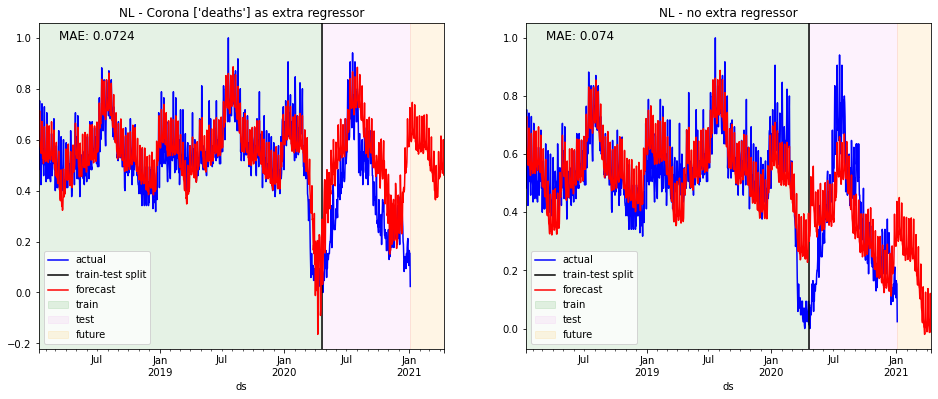

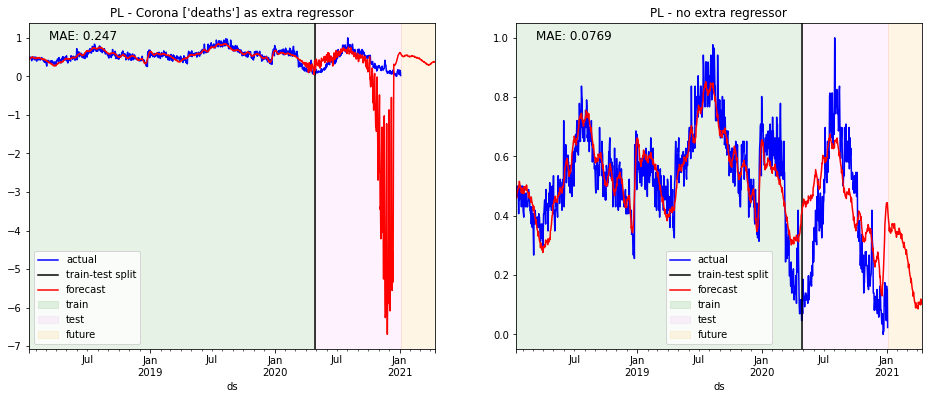

In [13]:

#perf1 = []
perf1 = pd.DataFrame(index=countries, columns=['with', 'no'])
add_regs = [True, False]

#variable = ['deaths']#, 'closure', 'opening']

variable = ['deaths']

titles = ['Corona {} as extra regressor'.format(variable), 'no extra regressor']

#countries.remove('IT') # Note
for c in countries:
    print(c)
    f, axes = plt.subplots(1,2, figsize=(16,6))
    for b, ax, t, cname in zip(add_regs, axes, titles, ['with', 'no']):
        data = prepara_data(outs, c)
        
        #interv_time_begin = data[data['closure']==1].index.values[0] 
        interv_time_begin = data[data['deaths']>0].index.values[0]
        #Split time accroding to first deaths 
        split_time = interv_time_begin  + np.timedelta64(45,'D')  
        
        forecast = get_forecast(data, split_time, variable=variable, add_regressor=b)
        
        
        data['y'].plot(ax=ax, c='blue', label='actual')
        ax.axvline(split_time, c='black', label='train-test split')
        forecast.set_index('ds')['yhat'].plot(ax=ax, c='red', label='forecast')
        ax.set_title(c + ' - ' + t)
        len_data = len(data['y'].values)
        mae = MAE(data['y'].values, forecast['yhat'].values[:len_data])
        textstr = 'MAE: {:5.3}'.format(mae)
        ax.text(0.05, 0.98, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top')
        print('MAE {:5.3}'.format(mae))
        start_train = data.index[0]
        start_test = data[:split_time].index[-1]
        start_future = data.index[-1]
        end_future = forecast['ds'].iloc[-1]
        ax.axvspan(date2num(start_train), date2num(start_test), alpha=0.1, color='green', label='train')
        ax.axvspan(date2num(start_test), date2num(start_future), alpha=0.1, color='violet', label='test')
        ax.axvspan(date2num(start_future), date2num(end_future), alpha=0.1, color='orange', label='future')
        ax.legend()
        #perf1.append(mae)
        perf1.loc[c, cname] = mae
    perf1['setting'] = '1regr'
    #plt.savefig(os.path.join(results_dir, c, 'forecast.jpg'))
    #plt.close()
    #break

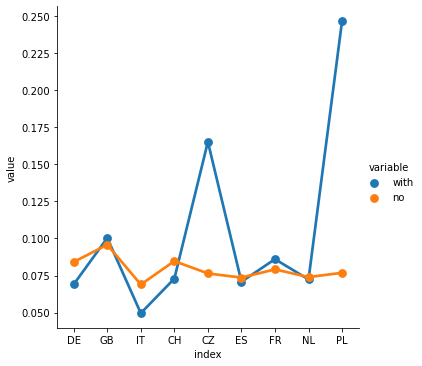

In [14]:
perf1 = perf1.reset_index()
d = pd.melt(perf1, id_vars='index', value_vars= ['with', 'no'] ) 
sns.catplot(data=d, x='index', y='value', hue='variable', kind='point')

## The same but weaken the effect of deaths

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DE


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0745
MAE 0.0842
GB


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.103


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0958
IT


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0556


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.069
CH


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.076


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0847
CZ


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.103


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0764
ES


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0609


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0736
FR


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0679
MAE 0.0792
NL


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.069


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.074
PL


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.158
MAE 0.0769


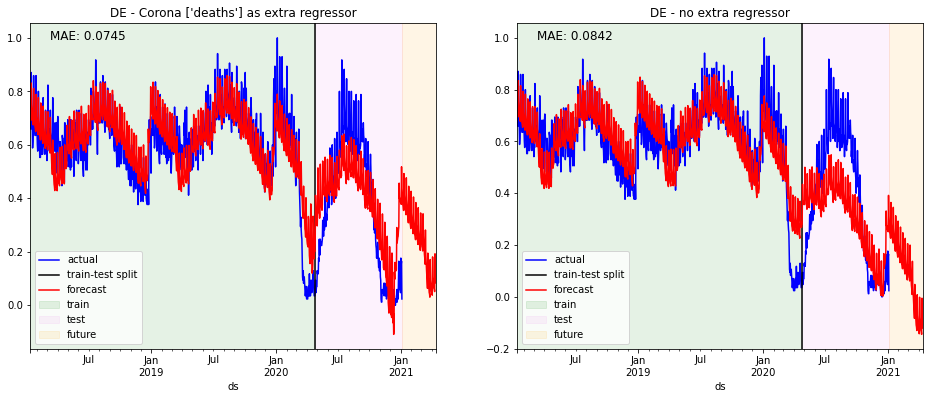

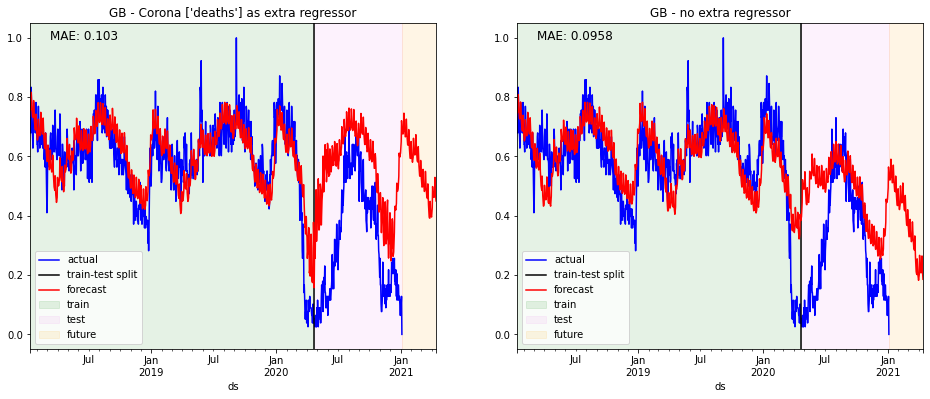

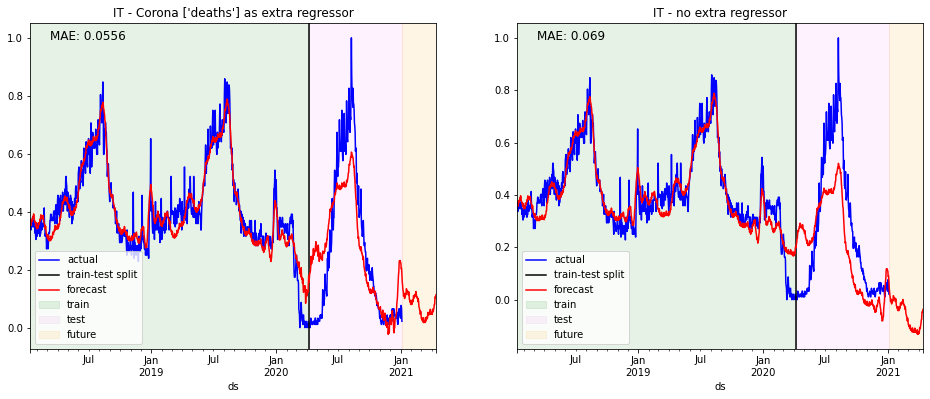

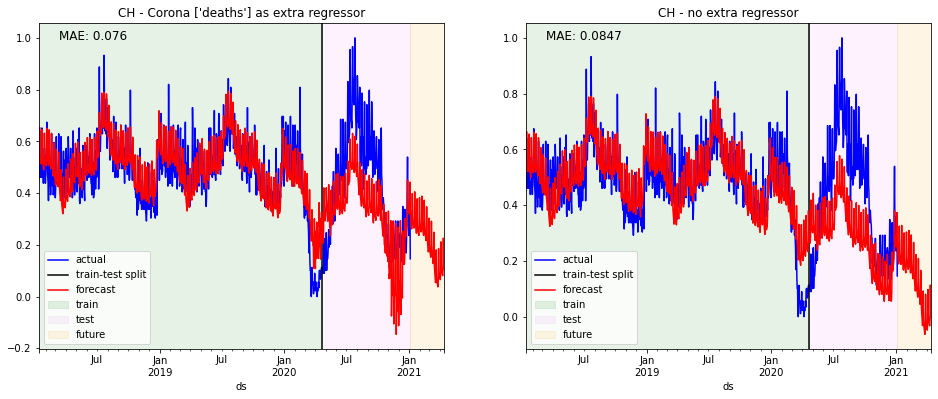

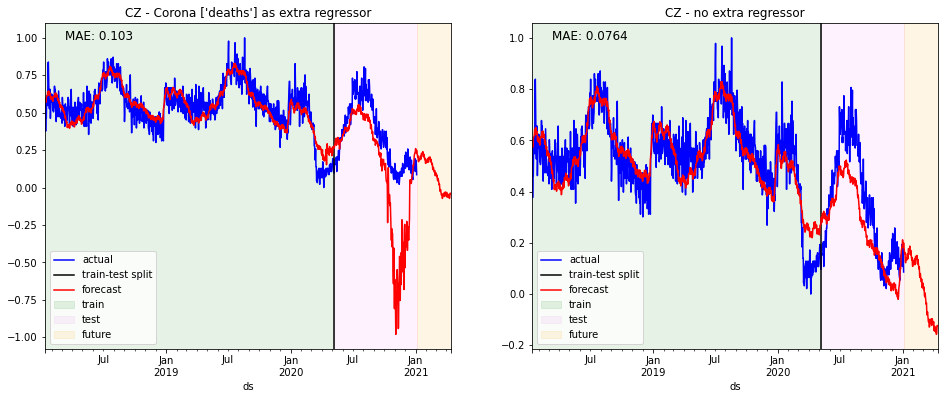

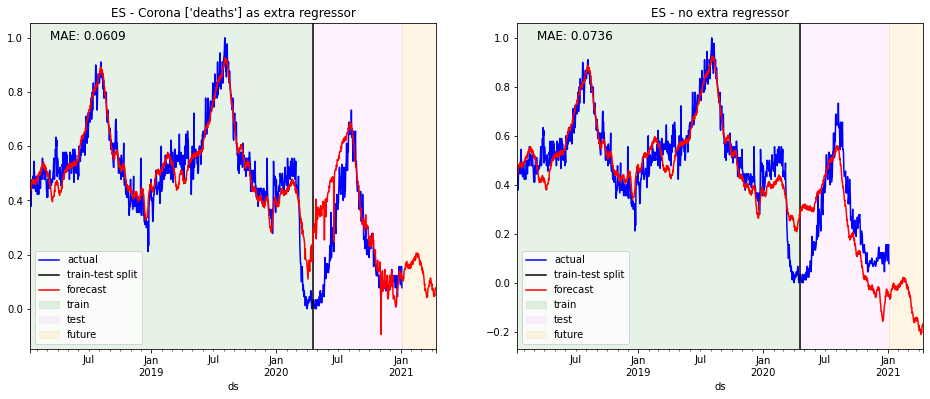

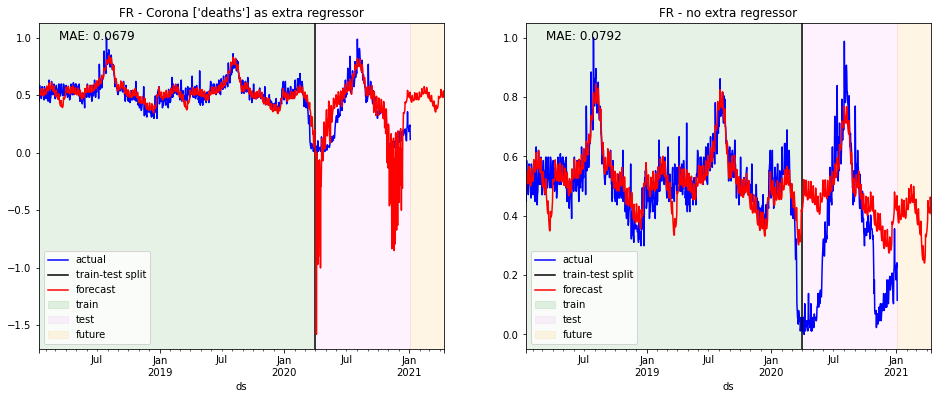

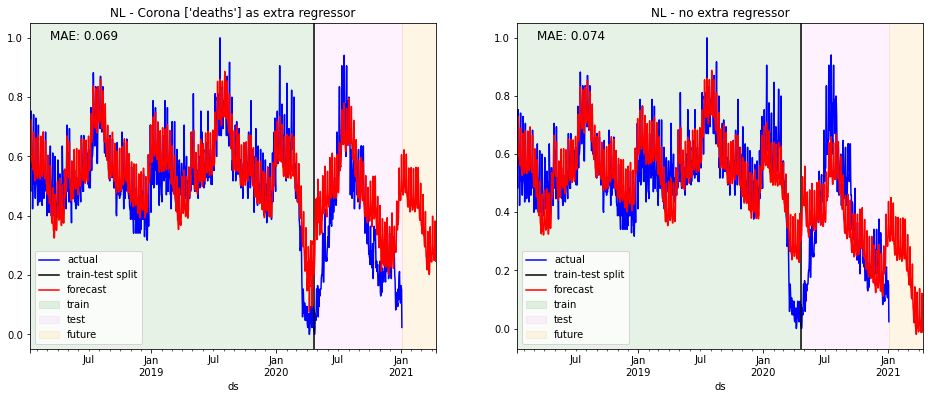

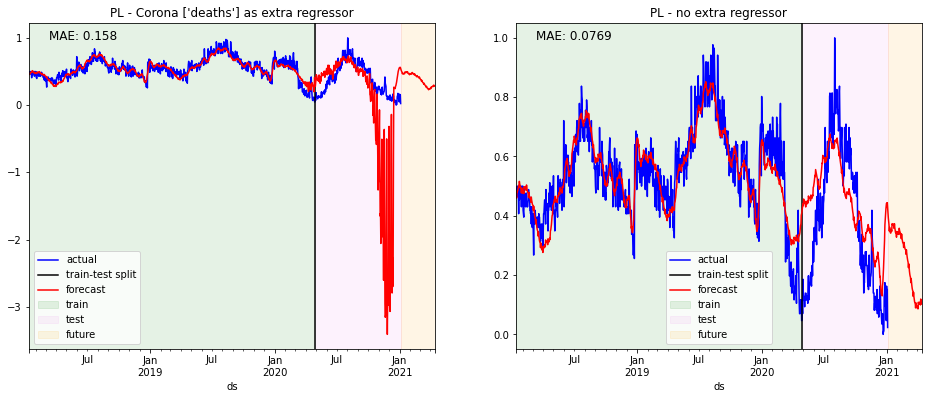

In [15]:
def get_forecast_dev(d, split, variable, add_regressor):
    m = Prophet(yearly_seasonality=20, changepoint_prior_scale=0.01)
    if add_regressor:
        for v in variable:
            m.add_regressor(v,  prior_scale=0.005, mode='multiplicative')
            #m.add_regressor(v,  prior_scale=0.05, mode='additive')
        
    train =  d.loc[:split].iloc[:-1].reset_index(drop=False)
    test = d.loc[split_time:].reset_index(drop=False)
    m.fit(train)
    extrasample = 100
    future = m.make_future_dataframe(periods=len(test)+extrasample, freq='1D')
    if add_regressor:
        future = add_regressor_to_future_with_nocorona(future, data[variable])
    forecast = m.predict(future)
    return forecast

perf2 = pd.DataFrame(index=countries, columns=['with', 'no'])
add_regs = [True, False]

variable = ['deaths']

titles = ['Corona {} as extra regressor'.format(variable), 'no extra regressor']

for c in countries:
    print(c)
    f, axes = plt.subplots(1,2, figsize=(16,6))
    for b, ax, t, cname in zip(add_regs, axes, titles, ['with', 'no']):
        data = prepara_data(outs, c)
        
        #interv_time_begin = data[data['closure']==1].index.values[0] 
        interv_time_begin = data[data['deaths']>0].index.values[0]
        #Split time accroding to first deaths 
        split_time = interv_time_begin  + np.timedelta64(45,'D')  
               
        forecast = get_forecast_dev(data, split_time, variable=variable, add_regressor=b)
        
        
        data['y'].plot(ax=ax, c='blue', label='actual')
        ax.axvline(split_time, c='black', label='train-test split')
        forecast.set_index('ds')['yhat'].plot(ax=ax, c='red', label='forecast')
        ax.set_title(c + ' - ' + t)
        len_data = len(data['y'].values)
        mae = MAE(data['y'].values, forecast['yhat'].values[:len_data])
        textstr = 'MAE: {:5.3}'.format(mae)
        ax.text(0.05, 0.98, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top')
        print('MAE {:5.3}'.format(mae))
        start_train = data.index[0]
        start_test = data[:split_time].index[-1]
        start_future = data.index[-1]
        end_future = forecast['ds'].iloc[-1]
        ax.axvspan(date2num(start_train), date2num(start_test), alpha=0.1, color='green', label='train')
        ax.axvspan(date2num(start_test), date2num(start_future), alpha=0.1, color='violet', label='test')
        ax.axvspan(date2num(start_future), date2num(end_future), alpha=0.1, color='orange', label='future')
        ax.legend()
        #perf2.append(mae)
        perf2.loc[c, cname] = mae
    perf2['setting'] = '1regr_weak'
    #plt.savefig(os.path.join(results_dir, c, 'forecast.jpg'))
    #plt.close()
    #break

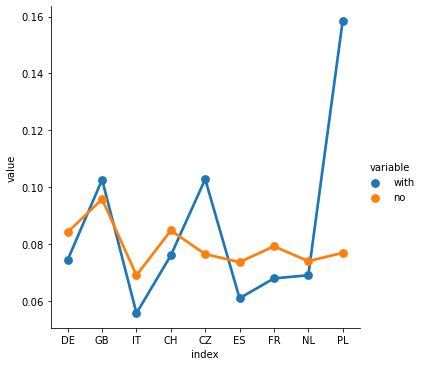

In [16]:
perf2 = perf2.reset_index()
d = pd.melt(perf2, id_vars='index', value_vars= ['with', 'no'] ) 
sns.catplot(data=d, x='index', y='value', hue='variable', kind='point')

## Two extra regressors: deaths and forecast for first country affected (IT or FR)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DE


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0727


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0842
GB


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0921


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0958
CH


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0735


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0847
CZ


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.231


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0764
ES


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0744


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0736
IT


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0503


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.069
NL


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0671


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.074
PL


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.281


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 0.0769


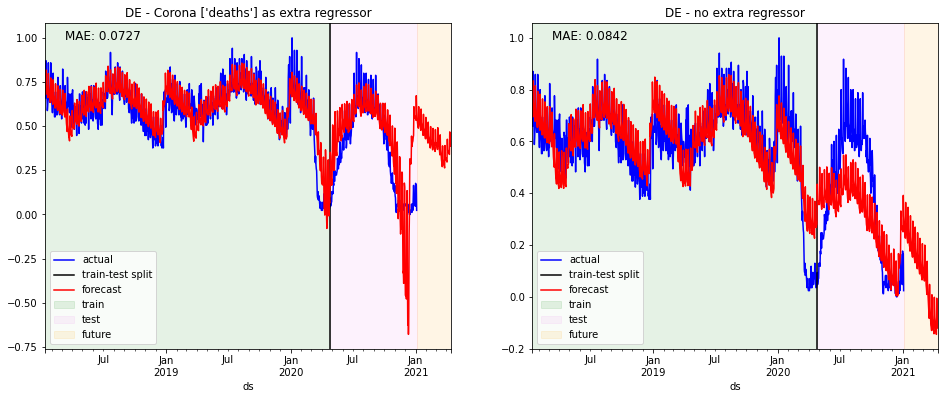

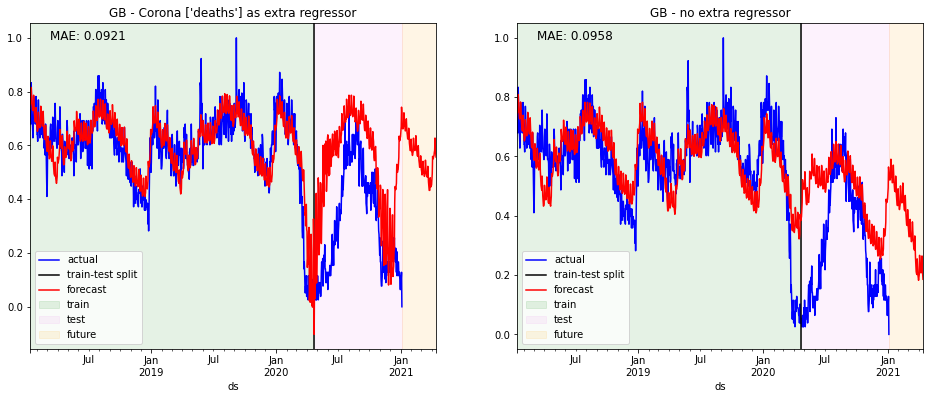

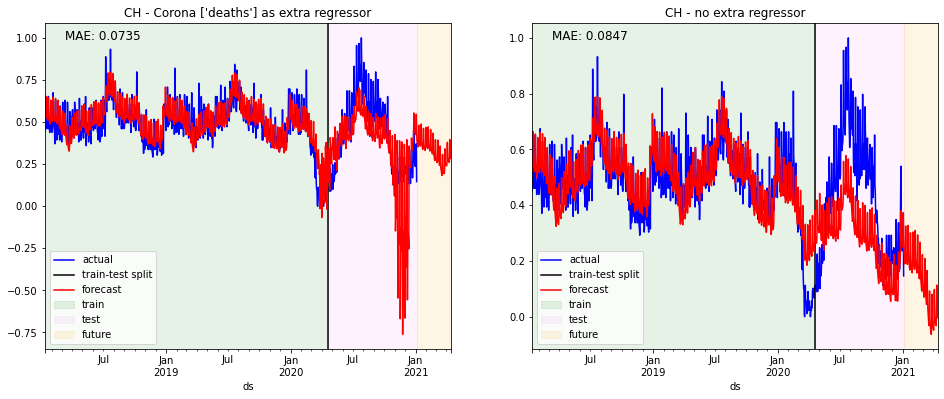

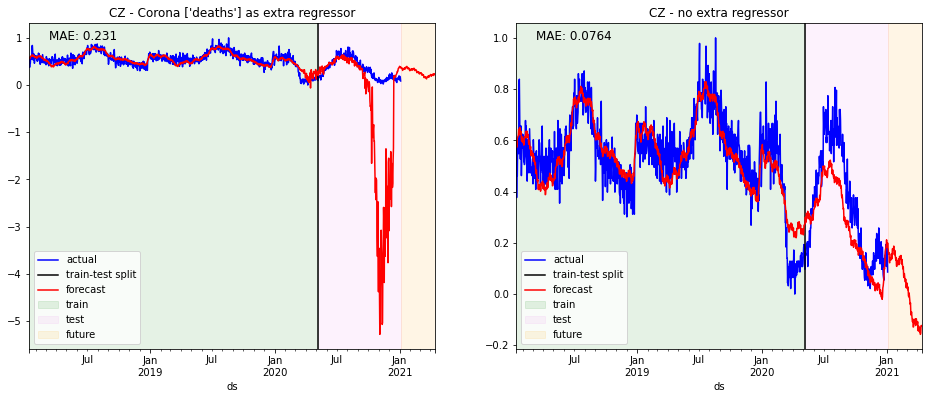

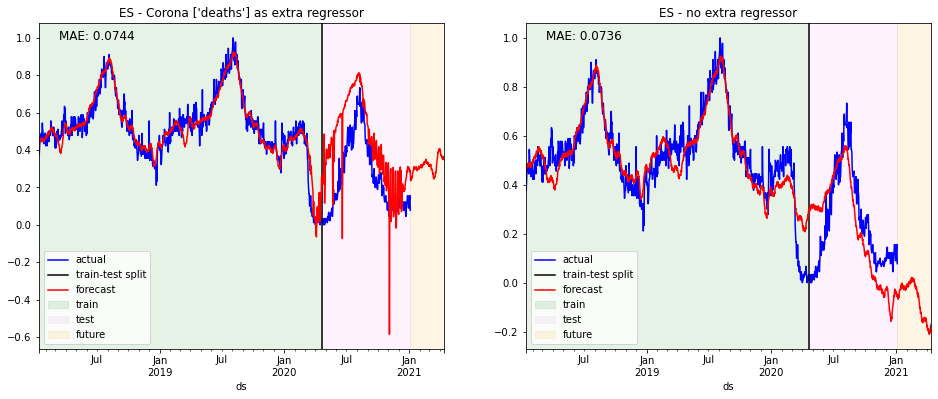

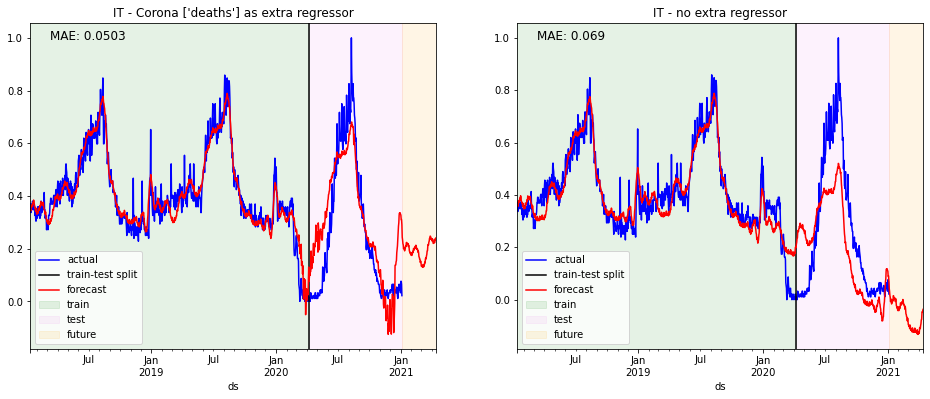

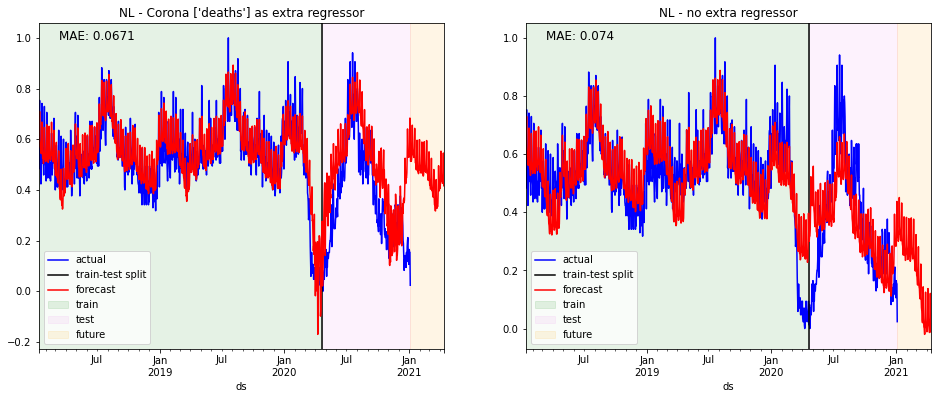

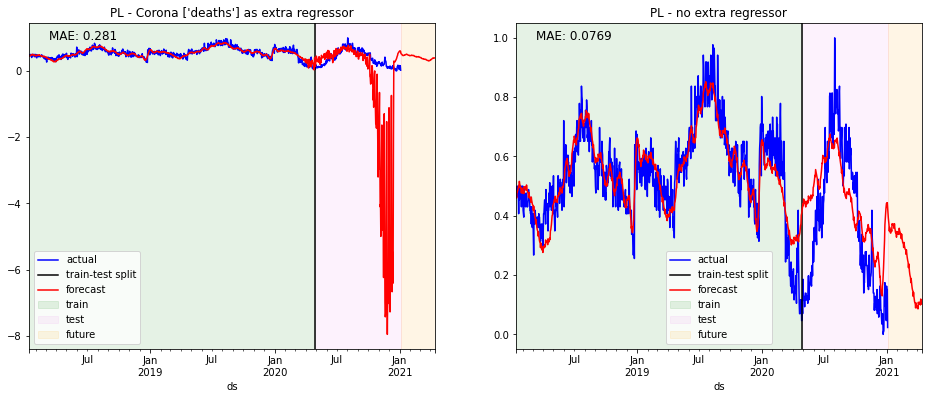

In [17]:
def get_forecast_dev(d, split, variable, add_regressor):
    m = Prophet(yearly_seasonality=20, changepoint_prior_scale=0.01)
    if add_regressor:
        for v in variable:
            m.add_regressor(v,  prior_scale=0.005, mode='multiplicative')
            #m.add_regressor(v,  prior_scale=0.05, mode='additive')
        
    train =  d.loc[:split].iloc[:-1].reset_index(drop=False)
    test = d.loc[split_time:].reset_index(drop=False)
    m.fit(train)
    extrasample = 100
    future = m.make_future_dataframe(periods=len(test)+extrasample, freq='1D')
    if add_regressor:
        future = add_regressor_to_future_with_nocorona(future, data[variable])
    forecast = m.predict(future)
    return forecast

#perf3 = []
perf3 = pd.DataFrame(index=countries, columns=['with', 'no'])
add_regs = [True, False]

countries = ['DE', 'GB', 'CH', 'CZ', 'ES', 'IT', 'NL', 'PL'] # drop FR
first_countr = 'FR'
for c in countries:
    print(c)
    f, axes = plt.subplots(1,2, figsize=(16,6))
    for b, ax, t, cname in zip(add_regs, axes, titles, ['with', 'no']):
        
        variable = ['deaths']
        titles = ['Corona {} as extra regressor'.format(variable), 'no extra regressor']
        
        data = prepara_data(outs, c)
        
        #interv_time_begin = data[data['closure']==1].index.values[0] 
        interv_time_begin = data[data['deaths']>0].index.values[0]
        #Split time accroding to first deaths 
        split_time = interv_time_begin  + np.timedelta64(45,'D')  
        
        ##
        #Prepate forecast for IT and use it as an extra regressor if b==True
        data_it = prepara_data(outs, first_countr)
        forecast_it = get_forecast(data_it, split_time, variable=variable, add_regressor=False)
        forecast_it = forecast_it[['ds','yhat']].set_index('ds')
        forecast_it = forecast_it.rename(columns={'yhat': 'yhat_it'})
        data = data.merge(forecast_it, left_index=True, right_index=True)
        variable = variable + ['yhat_it']
        #
        
        forecast = get_forecast(data, split_time, variable=variable, add_regressor=b)
        
        
        data['y'].plot(ax=ax, c='blue', label='actual')
        ax.axvline(split_time, c='black', label='train-test split')
        forecast.set_index('ds')['yhat'].plot(ax=ax, c='red', label='forecast')
        ax.set_title(c + ' - ' + t)
        len_data = len(data['y'].values)
        mae = MAE(data['y'].values, forecast['yhat'].values[:len_data])
        textstr = 'MAE: {:5.3}'.format(mae)
        ax.text(0.05, 0.98, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top')
        print('MAE {:5.3}'.format(mae))
        start_train = data.index[0]
        start_test = data[:split_time].index[-1]
        start_future = data.index[-1]
        end_future = forecast['ds'].iloc[-1]
        ax.axvspan(date2num(start_train), date2num(start_test), alpha=0.1, color='green', label='train')
        ax.axvspan(date2num(start_test), date2num(start_future), alpha=0.1, color='violet', label='test')
        ax.axvspan(date2num(start_future), date2num(end_future), alpha=0.1, color='orange', label='future')
        ax.legend()
        #perf3.append(mae)
        perf3.loc[c, cname] = mae
    perf3['setting'] = '2regr'
    #plt.savefig(os.path.join(results_dir, c, 'forecast.jpg'))
    #plt.close()


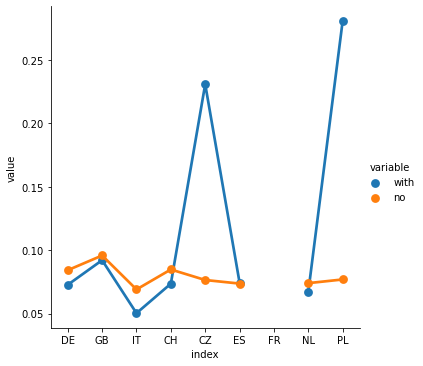

In [18]:
perf3 = perf3.reset_index()
d = pd.melt(perf3, id_vars='index', value_vars= ['with', 'no'] ) 
sns.catplot(data=d, x='index', y='value', hue='variable', kind='point')

## Plot all results combined

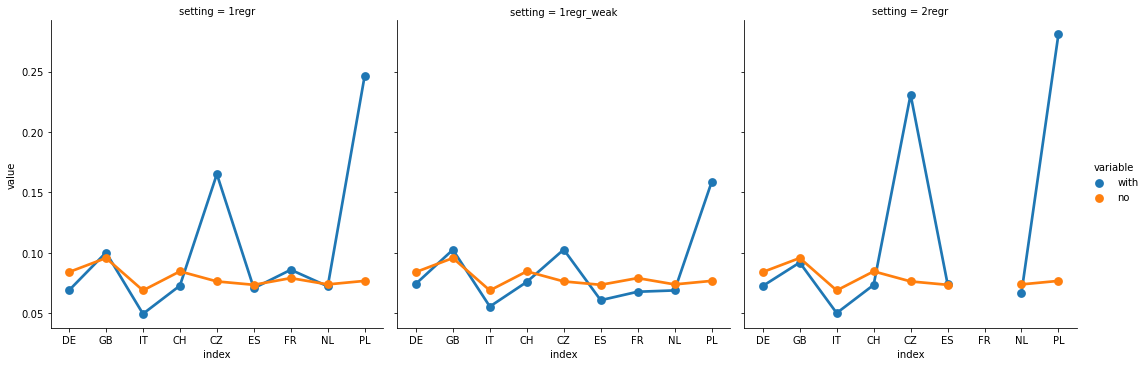

In [19]:
dd = pd.concat([perf1, perf2,perf3],0)
dd  = pd.melt(dd, id_vars=['index', 'setting'], value_vars= ['with', 'no'] ) 
sns.catplot(data=dd, x='index', y='value', hue='variable', kind='point', col='setting')
